In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [48]:
df = pd.read_csv("../data/real_final.csv")

In [49]:
# Target, feature 분리
y = df["Result"]
X = df.drop(columns=["Result"])

In [50]:
# 정규화 대상 컬럼과 인코딩 대상 분리
exclude_columns = ['GameDate', 'home_Team', 'away_Team']
X_to_scale = X.drop(columns=exclude_columns)

In [51]:
# 수치형 정규화
scaler = StandardScaler()
X_scaled_part = pd.DataFrame(scaler.fit_transform(X_to_scale), columns=X_to_scale.columns)

In [52]:
# 팀 정보 원-핫 인코딩
team_encoded = pd.get_dummies(
    X[["home_Team", "away_Team"]].reset_index(drop=True),
    columns=["home_Team", "away_Team"],
    prefix=["home_Team", "away_Team"]
).astype(int)

In [53]:
# 정규화된 수치 + 인코딩된 팀 정보 합치기
X_scaled = pd.concat([X_scaled_part.reset_index(drop=True), team_encoded], axis=1)

In [54]:
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=3, stratify=y
)

In [55]:
logreg = LogisticRegression(max_iter=1000)
logreg_params = {
    'C': np.logspace(-5, 4, 300),
}
logreg_search = GridSearchCV(logreg, logreg_params, cv=10, scoring='accuracy', return_train_score=True)
logreg_search.fit(X_train, y_train)
print("Best LogisticRegression Params:", logreg_search.best_params_)

Best LogisticRegression Params: {'C': np.float64(0.023509178754572868)}


In [56]:
# 최적 하이퍼파라미터 추출
logreg_best_params = logreg_search.best_params_

# 최종 모델 생성 및 학습
model = LogisticRegression(
    C=logreg_best_params['C'],
    max_iter=1000
)
model.fit(X_train, y_train)

LogisticRegression(C=np.float64(0.023509178754572868), max_iter=1000)

In [57]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_proba))
print("Test AUC :", roc_auc_score(y_test, y_test_proba))

Accuracy: 0.8729641693811075
AUC: 0.944979177290498
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       296
           1       0.87      0.88      0.88       318

    accuracy                           0.87       614
   macro avg       0.87      0.87      0.87       614
weighted avg       0.87      0.87      0.87       614

[[255  41]
 [ 37 281]]
Train Accuracy: 0.89119804400978
Test Accuracy : 0.8729641693811075
Train AUC: 0.9603772254679734
Test AUC : 0.944979177290498


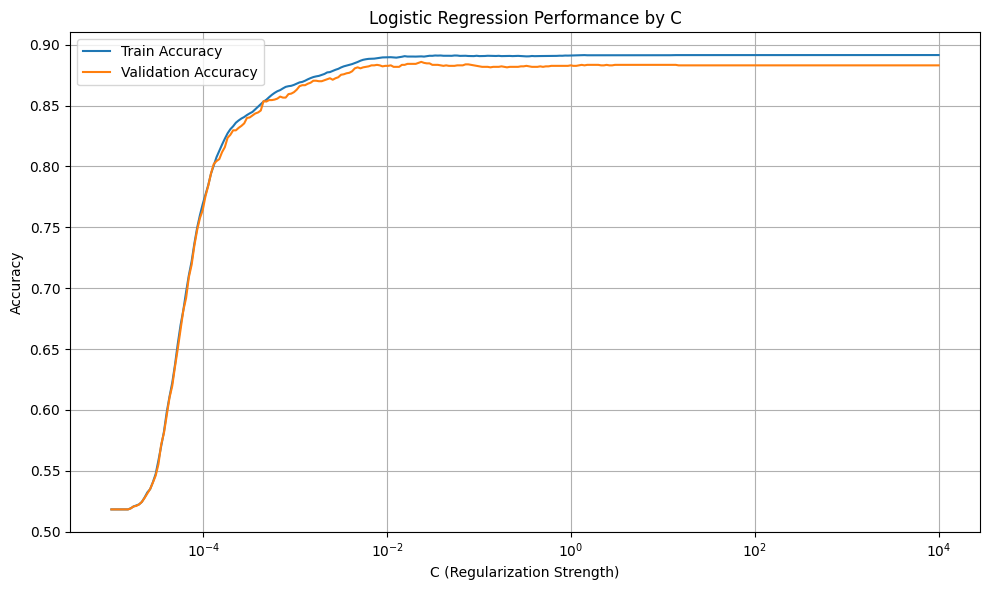

In [58]:
C_values = logreg_params['C']

# train, test scores 추출 (GridSearchCV 결과에서)
train_scores = logreg_search.cv_results_['mean_train_score']
test_scores = logreg_search.cv_results_['mean_test_score']

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_scores, label='Train Accuracy' )# , marker='o')
plt.plot(C_values, test_scores, label='Validation Accuracy') # , marker='s')
plt.xscale('log')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Performance by C')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
# 모델 + 스케일러 저장
joblib.dump(model, "./logistic_model.pkl")
print("모델 저장 완료!")

모델 저장 완료!


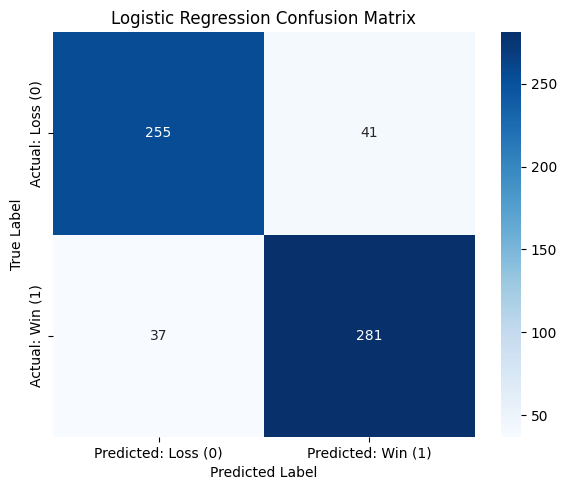

In [60]:
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: Loss (0)', 'Predicted: Win (1)'],
            yticklabels=['Actual: Loss (0)', 'Actual: Win (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.show()


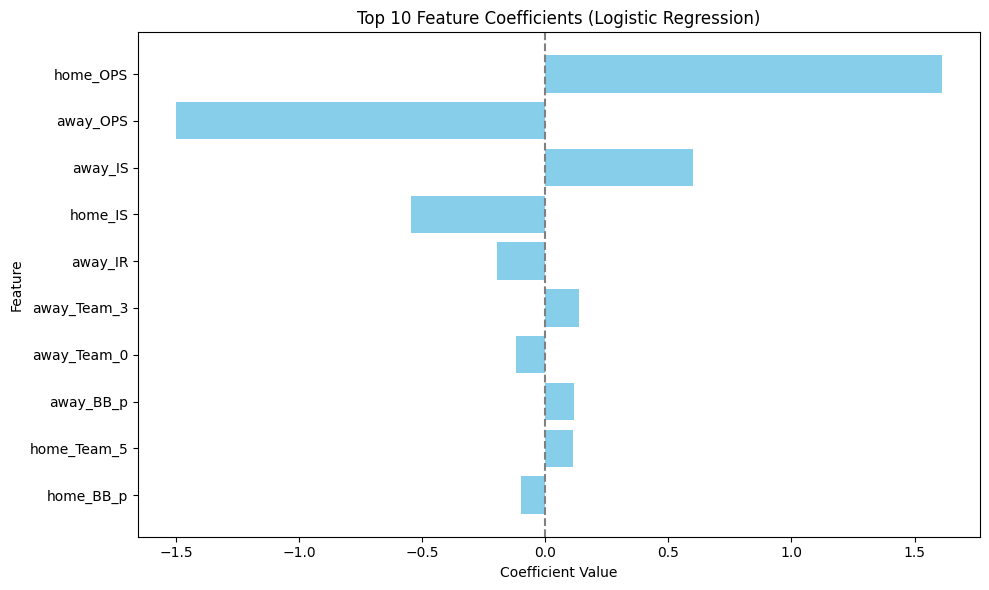

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 특성 이름과 계수 추출
feature_names = X_train.columns
coefficients = model.coef_[0]

# 절댓값 기준으로 상위 10개 정렬
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'AbsCoeff': np.abs(coefficients)
})
top_coef = coef_df.sort_values(by='AbsCoeff', ascending=False).head(10)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_coef['Feature'], top_coef['Coefficient'], color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Top 10 Feature Coefficients (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # 위에서 큰 값 나오게 정렬
plt.tight_layout()
plt.show()

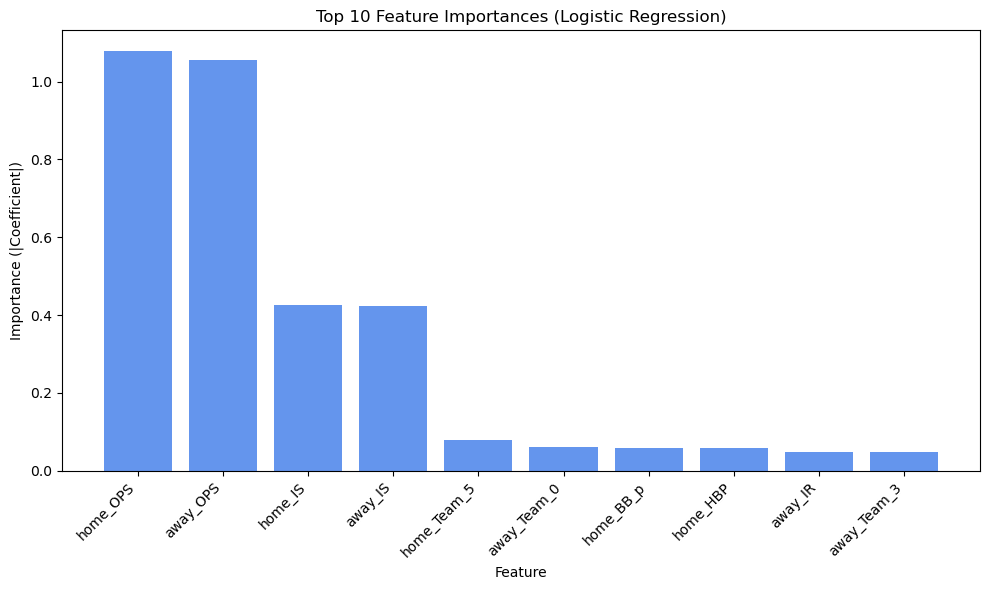

In [ ]:
# 변수 이름과 계수 가져오기
feature_names = X_train.columns
coefficients = model.coef_[0]

# 절댓값 기준 상위 10개 변수 정리
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False).head(10)

# 막대그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='cornflowerblue')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.xlabel('Feature')
plt.ylabel('Importance (|Coefficient|)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [62]:
X_train.to_csv('../models/X_train_logistic.csv', index=False)